### Test object detection using remote camer server, cleint

#### Run shared detector on bash
```bash
python3 /home/kiro-ros/Projects/rnb-planning/src/scripts/demo_202107/demo_utils/shared_detector.py
```


#### Run remote camera streaming server (robot-side pc)
```bash
python cam_grpc_sever.py
```

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import grpc
import cam_stream_grpc.RemoteCam_pb2
import cam_stream_grpc.RemoteCam_pb2_grpc
from cam_stream_grpc.cam_grpc_client import *

sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202208'))

In [2]:
CONNECT_CAM = False
ENABLE_DETECT = True

### Server - Client to get camera image

In [3]:
# generate cam client
cam_client = RemoteCam_Client()

Initialize Client Class to receive color, depth image from remote camera server
======= Success to receive camera config =======


In [4]:
# get camera configuraiton
config = cam_client.get_camera_config()

======= Success to receive camera config =======


In [5]:
# get color, depth image
color, depth = cam_client.get_image()

 ======= Success to receive color, depth image =======


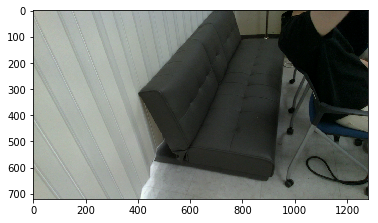

In [6]:
plt.imshow(color[:,:,[2,1,0]])

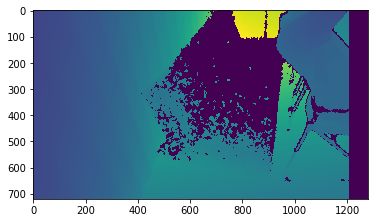

In [7]:
plt.imshow(depth)

### MultiIcp Detection

#### MaskRCNN

In [8]:
# shared detector
from scripts.demo_202208.cam_stream_grpc.demo_utils.shared_detector import SharedDetectorGenerator
sd = SharedDetectorGenerator(tuple(reversed(cam_client.img_dim))+(3,))()

if ENABLE_DETECT:
    sd.init()

In [9]:
# inference through CasCade MaskRCNN
mask_out_list = cam_client.inference(sd, color)

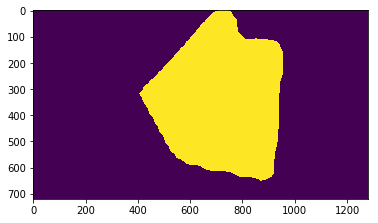

In [10]:
plt.imshow(mask_out_list[57])

#### ICP

In [3]:
from scripts.demo_202208.indy_utils.indydcp_client import IndyDCPClient

server_ip = "192.168.1.2"
robot_name = "NRMK-Indy7"
# robot_type = "left"

In [4]:
# generate indydcp client
indy = IndyDCPClient(server_ip, robot_name)

In [5]:
indy.connect()

Connect: Server IP (192.168.1.2)


True

In [ ]:
indy.connect()
indy.reset_robot()
indy.disconnect()

Connect: Server IP (192.168.1.2)


In [6]:
# Read current robot state (joint value)
indy.connect()
pos_cur_deg = indy.get_joint_pos()
print("\nCurrent robot pos[deg]:")
print(pos_cur_deg)

pos_cur = np.deg2rad(pos_cur_deg)
indy.disconnect()

Connect: Server IP (192.168.1.2)

Current robot pos[deg]:
[21.77812560530877, 14.76035882618899, -84.88096126840694, -31.458099667390684, -57.473180789762445, -81.40156660930302]


In [8]:
indy.connect()

for i in range(5):
    indy.joint_move_by([0,0,0,2*i,0,0])
    indy.wait_for_move_finish()

indy.disconnect()

Connect: Server IP (192.168.1.2)
Move finished!
Move finished!
Move finished!
Move finished!
Move finished!


In [16]:
##
# @brief simplify trajectory - divide each constant velocity section into 5 waypoints
def simplify_traj(trajectory, step_fractions=[0, 0.1, 0.5, 0.9, 1]):
    dq_pre = np.zeros(trajectory.shape[-1])
    traj_new = []
    traj_stack = []
    step_len = len(step_fractions)
    for q, q_nxt in zip(trajectory, np.pad(trajectory[1:], ((0, 1), (0, 0)), 'edge')):
        dq = (q_nxt-q)
        dq = dq / (np.linalg.norm(dq)+1e-16)
        traj_stack.append(q)
        if np.max(np.abs(dq-dq_pre)) > 1e-5:
            if len(traj_stack) > 1:
                if len(traj_stack) > step_len:
                    traj_stack = traj_stack[0] \
                                 + (traj_stack[-1] - traj_stack[0]) * np.array(step_fractions)[:, np.newaxis]
                traj_new.append(traj_stack[:-1])
            traj_stack = [q]
        dq_pre = dq
    traj_new.append(traj_stack[-1:])
    return np.concatenate(traj_new)

In [24]:
##
# @brief move joint with waypoints, one-by-one
# @param trajectory numpy array (trajectory length, joint num)
def move_joint_traj(indy, trajectory, auto_stop=True, wait_motion=True):
    Q_init = trajectory[0]
    Q_last = trajectory[-1]
#     Q_cur = self.get_qcur()
    Q_cur = np.deg2rad(indy.get_joint_pos())
    # assert np.max(np.abs((np.subtract(Q_init, Q_cur)))) < 5e-2, \
    #     "MOVE robot to trajectory initial: current robot pose does not match with trajectory initial state"

    traj_wps = simplify_traj(trajectory, step_fractions=[0, 1])

    # Joint Move
    POLICY_NO_COLLISION_DETECTION = 3
    prog = JsonProgramComponent(policy=POLICY_NO_COLLISION_DETECTION, resume_time=2)
    traj_vel = 1
    traj_blend = 3
    for Q in traj_wps:
        prog.add_joint_move_to(np.rad2deg(Q).tolist(), vel=traj_vel, blend=traj_blend)

    prog_json = prog.program_done()
    indy.set_and_start_json_program(prog_json)

    if wait_motion:
        time.sleep(0.5)
        with indy:
            indy.wait_for_move_finish()

In [21]:
from scripts.demo_202208.indy_utils.indy_program_maker import *

In [22]:
traj = [[0., 0.6244, -1.57, 0., -1.0293, 0.], 
        [0.0405339, 0.5100467, -1.56634566, -0.06086394, -0.96765581,  0.08058291], 
        [0.0810678,   0.39569339, -1.56269132, -0.12172788, -0.90601161,  0.16116583], 
        [0.1216017,   0.28134009, -1.55903698, -0.18259182, -0.84436742,  0.24174874], 
        [0.16213561,  0.16698678, -1.55538264, -0.24345575, -0.78272322,  0.32233166], 
        [0.20266951,  0.05263348, -1.5517283,  -0.30431969, -0.72107903,  0.40291457], 
        [0.24320341, -0.06171982, -1.54807395, -0.36518363, -0.65943483,  0.48349749], 
        [0.28373731, -0.17607313, -1.54441961, -0.42604757, -0.59779064,  0.5640804],
        [0.32427121, -0.29042643, -1.54076527, -0.48691151, -0.53614644,  0.64466332]]

In [23]:
indy.connect()
move_joint_traj(indy, np.array(traj))
indy.disconnect()

Connect: Server IP (192.168.1.2)


NameError: global name 'self' is not defined

In [ ]:
## Tc 계산해서 받아오기

In [11]:
Tc = np.identity(4)
T_cb = np.identity(4)

In [13]:
# object info
from scripts.demo_202208.cam_stream_grpc.demo_utils.config import *

obj_info_dict = get_obj_info()
micp_bed = MultiICP_Obj(obj_info_dict["bed"], None,
                        OffsetOnModelCoord("bed", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi/2)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))

mrule_closet = MaskBoxRule("closet", "bed", merge_rule=np.all)
mrule_closet.update_rule = ClosetRuleFun(mrule_closet)
micp_closet = MultiICP_Obj(obj_info_dict["closet"], 
                           mrule_closet,
                           OffsetOnModelCoord("closet", 
                                             offset=(0, 1, 0.3),
                                             use_median=True
                                     ))

micp_sofa = MultiICP_Obj(obj_info_dict["couch"], None,
                        OffsetOnModelCoord("couch", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi/2)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))

micp_refri = MultiICP_Obj(obj_info_dict["refrigerator"], None,
                        OffsetOnModelCoord("refrigerator", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi/2)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))


micp_dict = {"bed": micp_bed, "closet": micp_closet, "couch": micp_sofa, "refrigerator":micp_refri}

In [14]:
# initial guess for ICP (object location from kiro)

Tbo_bed = np.identity(4)
Tbo_closet = np.identity(4)
Tbo_sofa = np.identity(4)
Tbo_refri = np.identity(4)

initial_list = {"bed":Tbo_bed, "closet":Tbo_closet, "couch":Tbo_sofa, "refrigerator":Tbo_refri,}

In [15]:
cam_client.set_config(micp_dict, sd, initial_list)

In [16]:
cam_client.set_merge_mask(merge=True)
cam_client.set_inlier_ratio(ratio=0.02)
cam_client.detect(sd, Tc, "couch", visualize=True)

[Info] name_mask is couch
 ======= Success to receive color, depth image =======
===== Detected : couch, 1 object(s) =====
[NOTICE] You choose merge option for mask. Detected masks would be merged.

 Use intial guess of 'couch'

initial: 
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


cam_stream_grpc/demo_utils/rotation_utils.py:304: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(z/radius)
cam_stream_grpc/cam_grpc_client.py:763: RuntimeWarning: divide by zero encountered in divide
  points_converted = points_converted[np.where(np.abs(points_converted[:,0]/points_converted[:,2]) < np.tan(h_fov_hf))]


Apply point-to-point ICP
registration::RegistrationResult with fitness=3.247261e-01, inlier_rmse=4.836201e-02, and correspondence_set size of 830
Access transformation to get result.
Transformation is:
[[ 0.98179387 -0.18034432  0.0596383  -0.12120694]
 [ 0.1728816   0.71831553 -0.67389521  1.08313834]
 [ 0.07869406  0.67193655  0.736416    0.45893669]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.98179387 -0.18034432  0.0596383  -0.12120694]
 [ 0.1728816   0.71831553 -0.67389521  1.08313834]
 [ 0.07869406  0.67193655  0.736416    0.45893669]
 [ 0.          0.          0.          1.        ]]
result: 
[[ 0.98 -0.18  0.06 -0.12]
 [ 0.17  0.72 -0.67  1.08]
 [ 0.08  0.67  0.74  0.46]
 [ 0.    0.    0.    1.  ]]
Inlier ratio: 0.0129750715161


{}

In [17]:
cam_client.objectPose_dict

{}

In [ ]:
# # option to detect
# micp.set_ICP_thres(thres_ICP=0.6, thres_front_ICP=0.18)
# micp.set_pcd_ratio(ratio=0.5)
# micp.set_inlier_ratio(ratio=0.02)
# # micp.set_multiobject_num(num = 1)
# micp.set_merge_mask(merge=True)

In [ ]:
# detect
# micp.detect(sd, Tc, "bed")
# micp.detect(sd, Tc, "closet")
# micp.detect(sd, Tc, "sofa")
# micp.detect(sd, Tc, "refrigerator")

## TODO

### 요청
* 카메라 연결선 교체요청 (c-type-c-type으로 안되는듯. c-type-usb가 되던가 해야할듯 L515카메라에서)
* 인디 자꾸 이더캣 연결 불안정해서 끊기는 현상 발생 --> 계속 생기면 조치 취해달라 요청

### 수행
* Robot Model 수정 (6축 돌아간거 반영 + 카메라 geometry)
* End-tool 통신 및 구동 확인
* Kiro측과 grpc 연동
* 닦기 작업전략 어떻게 할 지 + F/T sensor 정보